In [287]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [288]:
transform = transforms.Compose([
    transforms.ToTensor()
])

full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
bird_dataset = [data for data in full_dataset if data[1] == 2]  # Select only birds 
plane_dataset = [data for data in full_dataset if data[1] == 0]  # Select only planes

bird_and_plane_dataset = bird_dataset + plane_dataset




In [289]:
train_loader = torch.utils.data.DataLoader(bird_and_plane_dataset, batch_size=64, shuffle=True)
bird_loader = torch.utils.data.DataLoader(bird_dataset, batch_size=64, shuffle=True)
plane_loader = torch.utils.data.DataLoader(plane_dataset, batch_size=64, shuffle=True)

In [827]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=64*4*4, out_features=latent_dim)  # Adjusted for new layer size
        self.fc_log_var = nn.Linear(in_features=64*4*4, out_features=latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*4*4)  # Adjusted for new layer size
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var


In [878]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dim, out_features=64*4*4)  # Adjusted for new layer size
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 64, 4, 4)  # Adjusted for new layer size
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        reconstruction = torch.sigmoid(self.deconv3(z))
        return reconstruction


In [879]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) # eps -> 
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


In [880]:


# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()

print("CUDA available:", is_cuda_available)

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

print("Using device:", device)


CUDA available: False
Using device: cpu


In [881]:
latent_dim = 30  # Example latent space dimension
vae = VAE(latent_dim)
vae.to(device)


VAE(
  (encoder): ConvEncoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=1024, out_features=30, bias=True)
    (fc_log_var): Linear(in_features=1024, out_features=30, bias=True)
  )
  (decoder): ConvDecoder(
    (fc): Linear(in_features=30, out_features=1024, bias=True)
    (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv3): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [885]:
# Example using Binary Cross Entropy
reconstruction_loss_function = nn.BCELoss(reduction='sum')

beta = 0.1 # Example value; you may need to experiment to find the best value for your model

def loss_function(recon_x, x, mu, logvar, beta):
    recon_loss = reconstruction_loss_function(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return  recon_loss + beta * kl_div



In [886]:
def train(model, dataloader, optimizer, epoch, device):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Calculate loss
        loss = loss_function(recon_batch, data, mu, logvar, beta)

        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Print average loss for the epoch
    avg_loss = train_loss / len(dataloader.dataset)
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')



In [887]:
# Model, Optimizer, and DataLoader setup
# vae = ...
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# train_loader = ...
# beta = 0.5
# Training process
num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train(vae, train_loader, optimizer, epoch, device)


Epoch 1, Average Loss: 1967.5249
Epoch 2, Average Loss: 1871.0610
Epoch 3, Average Loss: 1852.5763
Epoch 4, Average Loss: 1821.4211
Epoch 5, Average Loss: 1808.5549
Epoch 6, Average Loss: 1802.1464
Epoch 7, Average Loss: 1798.3728
Epoch 8, Average Loss: 1794.7995
Epoch 9, Average Loss: 1792.3967
Epoch 10, Average Loss: 1791.2803
Epoch 11, Average Loss: 1790.2998
Epoch 12, Average Loss: 1789.3863
Epoch 13, Average Loss: 1789.3541
Epoch 14, Average Loss: 1788.6420
Epoch 15, Average Loss: 1788.3276
Epoch 16, Average Loss: 1788.0760
Epoch 17, Average Loss: 1787.6940
Epoch 18, Average Loss: 1787.2135
Epoch 19, Average Loss: 1787.0913
Epoch 20, Average Loss: 1787.0934
Epoch 21, Average Loss: 1786.7761
Epoch 22, Average Loss: 1786.5245
Epoch 23, Average Loss: 1786.1171
Epoch 24, Average Loss: 1786.1291
Epoch 25, Average Loss: 1785.6111


In [888]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
test_loader = torch.utils.data.DataLoader(bird_and_plane_dataset, batch_size=64, shuffle=True)
images, _ = next(iter(test_loader))


In [889]:
# Ensure the model is in evaluation mode
vae.eval()

# Move images to the same device as the model
images = images.to(device)

# Get the reconstructed images
with torch.no_grad():
    reconstructed, _, _ = vae(images)


In [890]:
# print the shape of reconstructed: torch.Size([64, 3, 32, 32]) also the images
print("the shape of reconstructed:", reconstructed.shape, "also the images", images.shape)

the shape of reconstructed: torch.Size([64, 3, 32, 32]) also the images torch.Size([64, 3, 32, 32])


In [891]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CxHxW to HxWxC
    plt.axis('off')

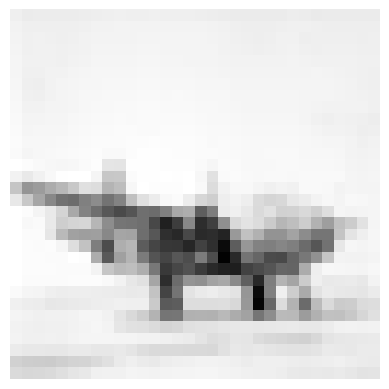

In [892]:
# Plot a single image to debug
imshow(images[3].cpu())  # Make sure to move it to CPU if it's on GPU
plt.show()


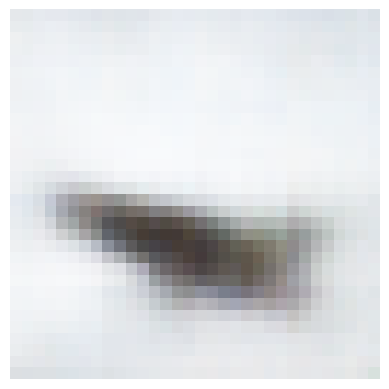

In [893]:
# Plot a single image to debug
imshow(reconstructed[3].cpu())  # Make sure to move it to CPU if it's on GPU
plt.show()
# beta = 0.5

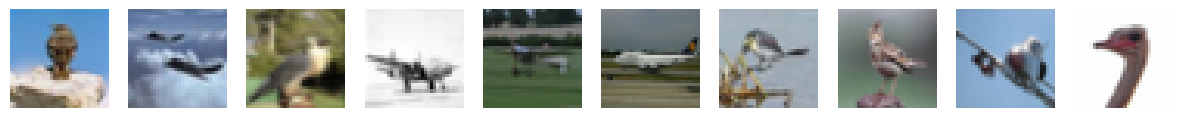

In [894]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random

# Define the imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CxHxW to HxWxC
    plt.axis('off')

# Assuming 'images' is a batch of images from DataLoader
# Display 10 random images from the batch
fig = plt.figure(figsize=(15, 1.5))  # Larger width to accommodate 10 images
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])   

plt.show()


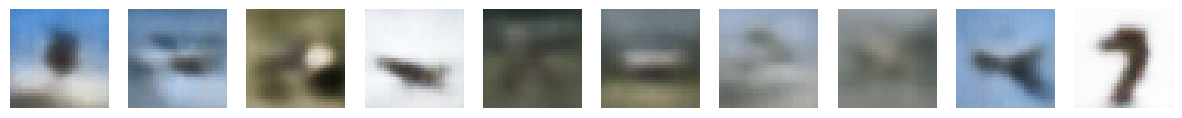

In [895]:
fig = plt.figure(figsize=(15, 1.5))  # Larger width to accommodate 10 images
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    imshow(reconstructed[i])   

plt.show()

Now we will implement a binary classifier to see if the decoded images after latent space manipulation will come out as planes or not.

In [901]:
class_indices = {'plane': 0, 'bird': 2}  # CIFAR-10 class indices for plane and bird

binary_dataset = bird_and_plane_dataset


# Assign binary labels: 0 for planes, 1 for birds
for i, (data, label) in enumerate(binary_dataset):
    binary_label = 0 if label == class_indices['plane'] else 1
    binary_dataset[i] = (data, binary_label)

# Create a DataLoader
binary_loader = DataLoader(binary_dataset, batch_size=64, shuffle=True)


In [902]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 output classes: plane and bird

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BinaryClassifier().to(device)


In [903]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(25):
    for data, target in binary_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/25, Loss: 0.3869885206222534
Epoch 2/25, Loss: 0.31608179211616516
Epoch 3/25, Loss: 0.13429847359657288
Epoch 4/25, Loss: 0.22973529994487762
Epoch 5/25, Loss: 0.14697904884815216
Epoch 6/25, Loss: 0.1578674167394638
Epoch 7/25, Loss: 0.2101529836654663
Epoch 8/25, Loss: 0.20259825885295868
Epoch 9/25, Loss: 0.17223571240901947
Epoch 10/25, Loss: 0.27879998087882996
Epoch 11/25, Loss: 0.11394539475440979
Epoch 12/25, Loss: 0.16682922840118408
Epoch 13/25, Loss: 0.22415637969970703
Epoch 14/25, Loss: 0.05068466067314148
Epoch 15/25, Loss: 0.100047767162323
Epoch 16/25, Loss: 0.17966242134571075
Epoch 17/25, Loss: 0.004348826128989458
Epoch 18/25, Loss: 0.15282626450061798
Epoch 19/25, Loss: 0.15926219522953033
Epoch 20/25, Loss: 0.0489192008972168
Epoch 21/25, Loss: 0.00936329085379839
Epoch 22/25, Loss: 0.293605238199234
Epoch 23/25, Loss: 0.023424919694662094
Epoch 24/25, Loss: 0.016141751781105995
Epoch 25/25, Loss: 0.1841454803943634


In [904]:
# CIFAR-10 classes: ['airplane', 'automobile', 'bird', 
# 
# 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_indices = {'plane': 0, 'bird': 2}

# Load CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter out the test set for birds and planes
test_binary_dataset = [data for data in test_dataset if data[1] in class_indices.values()]

# Assign binary labels: 0 for planes, 1 for birds
for i, (data, label) in enumerate(test_binary_dataset):
    binary_label = 0 if label == class_indices['plane'] else 1
    test_binary_dataset[i] = (data, binary_label)

# Create a DataLoader for the test set
test_loader = DataLoader(test_binary_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified


In [905]:
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.0f}%)')


Test set: Average loss: 0.0062, Accuracy: 1788/2000 (89%)


Now let's do a PCA on the latent space to see if we can get a better understanding of the latent space.

In [906]:
len(test_loader.dataset)

2000

In [907]:
data, target = next(iter(test_loader))
len(data)

64

In [908]:
data.shape

torch.Size([64, 3, 32, 32])

In [909]:
# Let's assume you have a DataLoader that loads batches of images
# And you want to collect individual latent vectors for each image

latent_vectors = []
images = []
a=1
for i, (data, label) in enumerate(test_loader):
    data = data.to(device)
    if i == 0:
        print(data.shape)
    for image in data:
        if a == 1:
            print(image.shape)
            a=0
        images.append(image)  # Save the image for later
        with torch.no_grad():
            mu, _ = vae.encoder(image)
            latent_vectors.extend(mu)  # This will add individual vectors if mu is a batch of vectors



torch.Size([64, 3, 32, 32])
torch.Size([3, 32, 32])


In [910]:
len(latent_vectors)  # Should be 2000 if you're using the test set

2000

In [911]:
latent_vectors[0].shape

torch.Size([30])

In [912]:
from sklearn.decomposition import PCA

# Flatten the latent vectors and perform PCA
all_latent_vectors = torch.cat(latent_vectors, dim=0).cpu().numpy()
all_latent_vectors = all_latent_vectors.reshape(-1, latent_dim)
pca = PCA(n_components=15)
pca_latent_vectors = pca.fit_transform(all_latent_vectors)


In [913]:
all_latent_vectors.shape

(2000, 30)

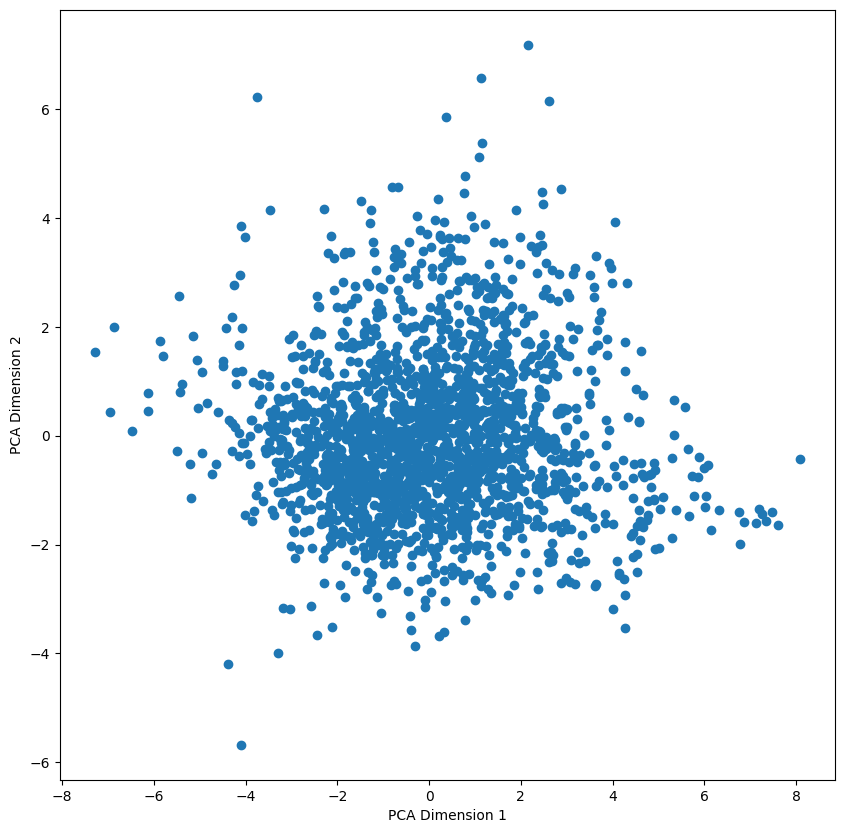

In [914]:
# Plot the first two dimensions of the latent vectors
plt.figure(figsize=(10, 10))
plt.scatter(pca_latent_vectors[:, 0], pca_latent_vectors[:, 1])
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()


In [915]:
pca_latent_vectors.shape

(2000, 15)

In [916]:
manipulated_latents = []
for vec in pca_latent_vectors:
    # Manipulate along the first principal component
    vec[0] += -5  # Adjust this value as needed
  # Adjust this value as needed
    manipulated_latents.append(vec)


In [917]:
len(manipulated_latents)

2000

In [918]:
inverse_transformed_latents = pca.inverse_transform(manipulated_latents)

In [919]:
len(inverse_transformed_latents)

2000

In [920]:
manipulated_images = []
for vec in inverse_transformed_latents:
    vec_tensor = torch.tensor(vec).float().unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        reconstructed_img = vae.decoder(vec_tensor)
        manipulated_images.append(reconstructed_img.squeeze(0))  # Remove batch dimension


In [921]:
len(manipulated_images)

2000

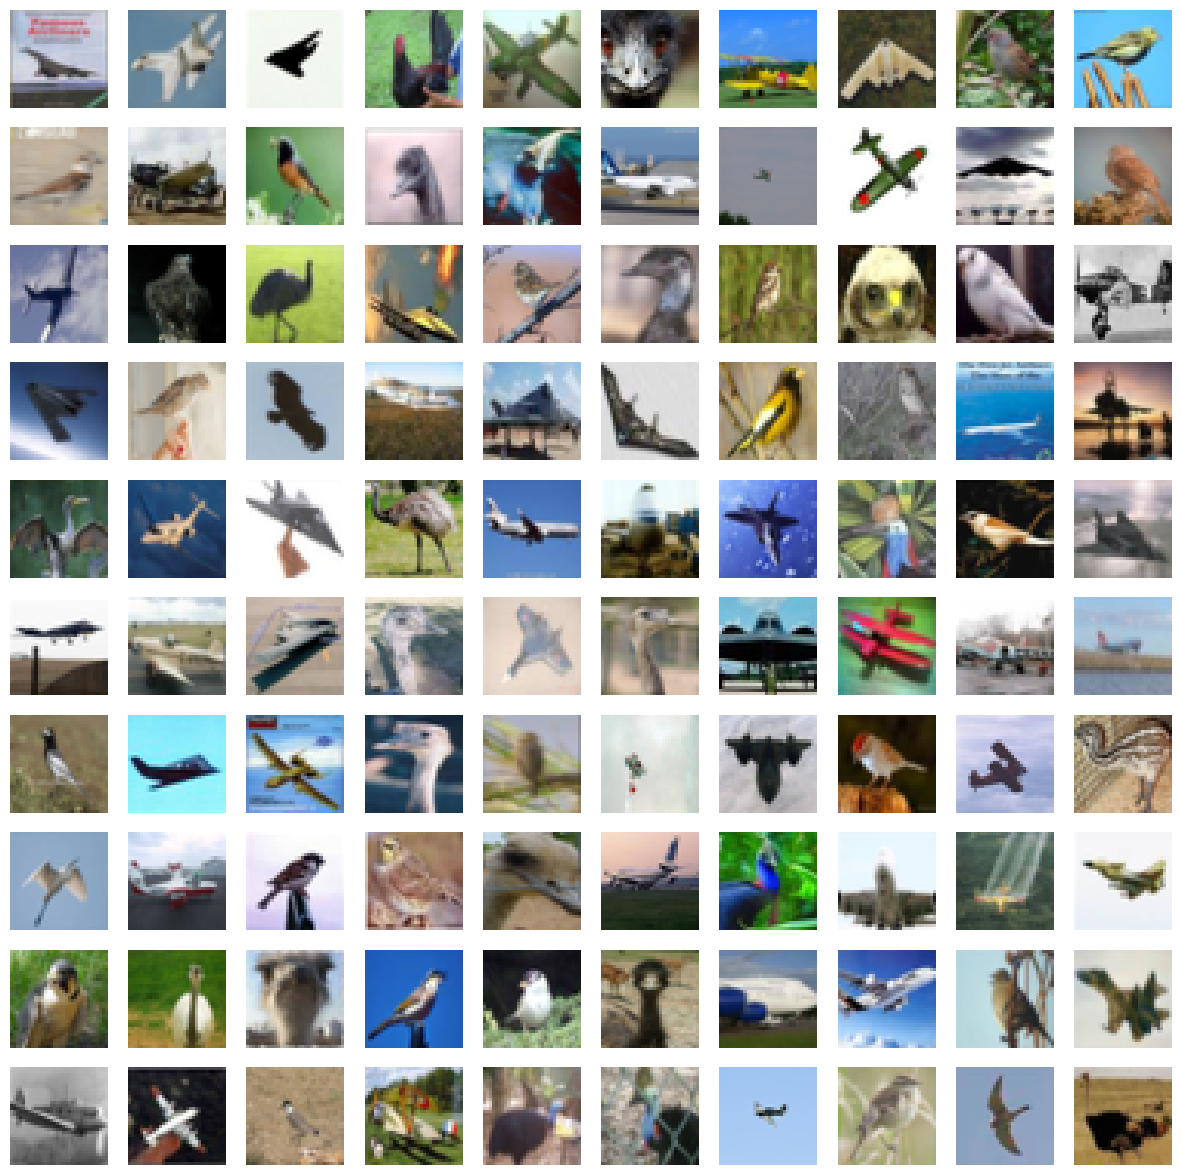

In [922]:
# Plot the original images in a grid
plt.figure(figsize=(15, 15))
for i, image in enumerate(images):
    if i == 100:
        break
    ax = plt.subplot(10, 10, i+1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')

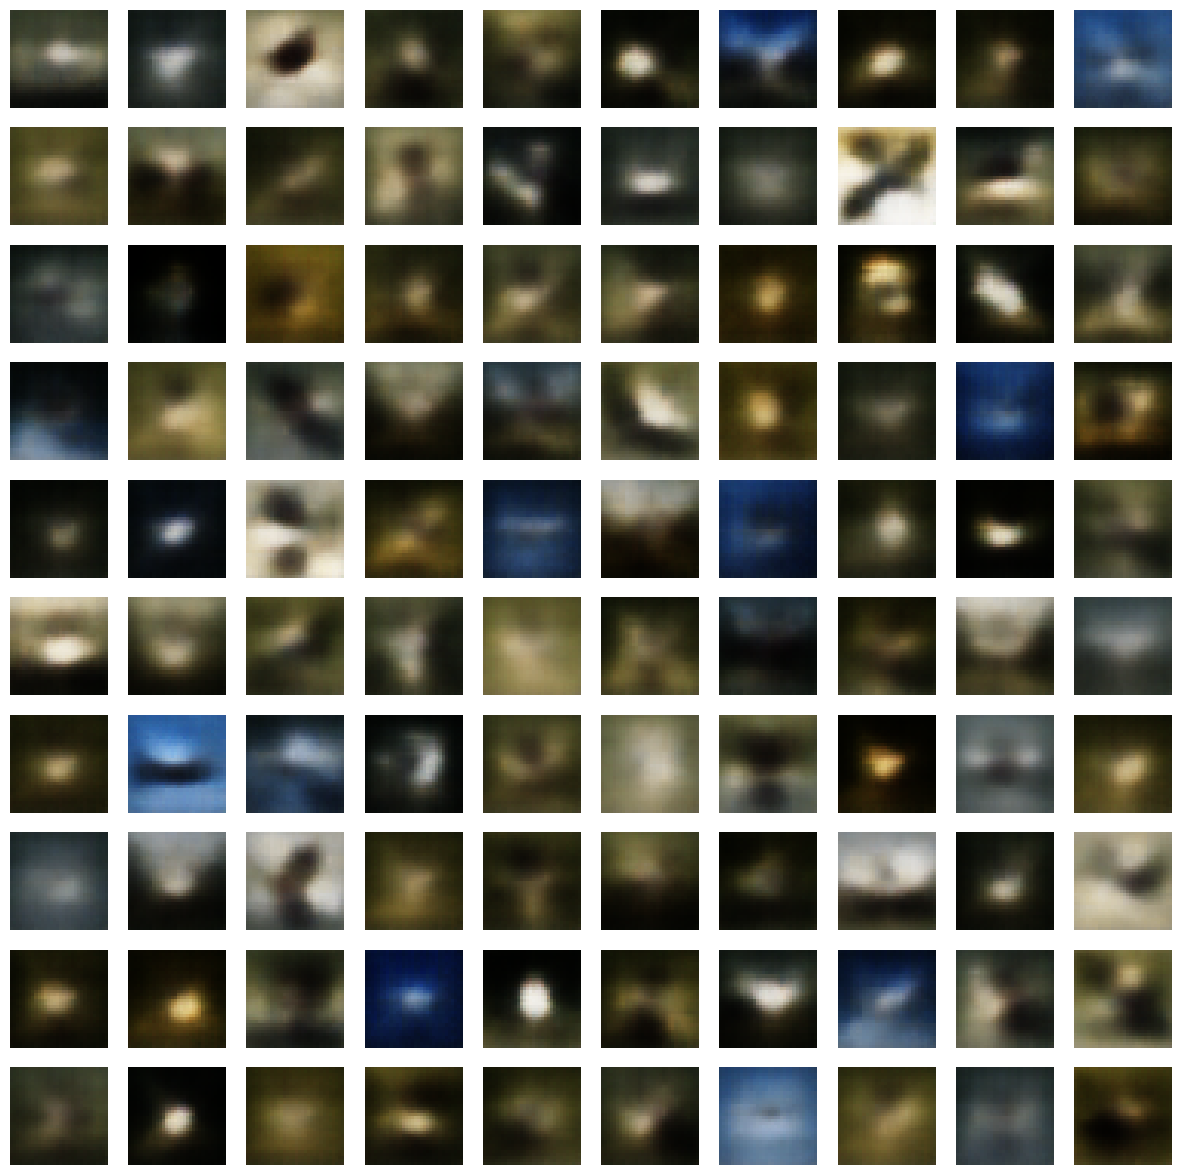

In [923]:
# Plot the original images in a grid
plt.figure(figsize=(15, 15))
for i, image in enumerate(manipulated_images):
    if i == 100:
        break
    ax = plt.subplot(10, 10, i+1)
    plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')

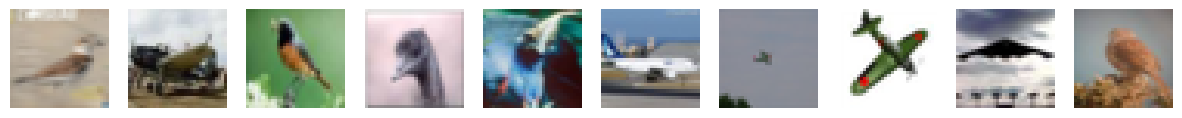

In [929]:
fig = plt.figure(figsize=(15, 1.5))  # Larger width to accommodate 10 images
for i in range(10,20):
    ax = fig.add_subplot(1, 10, i-9, xticks=[], yticks=[])
    imshow(images[i])   

plt.show()

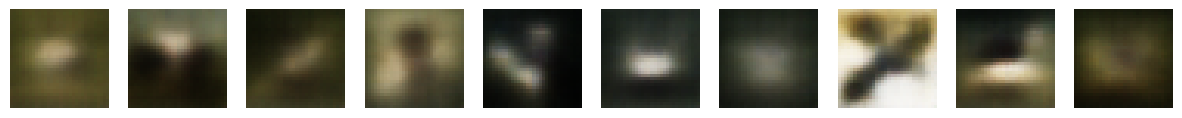

In [930]:
fig = plt.figure(figsize=(15, 1.5))  # Larger width to accommodate 10 images
for i in range(10,20):
    ax = fig.add_subplot(1, 10, i-9, xticks=[], yticks=[])
    imshow(manipulated_images[i])   

plt.show()

In [751]:
# see how many manipulated image there are

len(manipulated_images)



2000

In [752]:
# Step 1: Classify Original Images
original_classifications = []
for image in images:
    with torch.no_grad():
        output = model(image)  # `model` is your binary classifier
        pred = output.argmax(dim=1)
        original_classifications.extend(pred.tolist())

# Count initial classifications
original_birds = original_classifications.count(1)
original_planes = original_classifications.count(0)

# Step 2: Manipulate Images
# ... Manipulate using PCA and VAE ...

# Step 3: Classify Manipulated Images
manipulated_classifications = []
for manipulated_image in manipulated_images:  # assuming this is a list of tensors
    manipulated_image = manipulated_image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(manipulated_image)
        pred = output.argmax(dim=1)
        manipulated_classifications.extend(pred.tolist())

# Count manipulated classifications
manipulated_birds = manipulated_classifications.count(1)
manipulated_planes = manipulated_classifications.count(0)

# Step 4: Compare Results
print("Original - Birds:", original_birds, "Planes:", original_planes)
print("Manipulated - Birds:", manipulated_birds, "Planes:", manipulated_planes)


Original - Birds: 987 Planes: 1013
Manipulated - Birds: 1972 Planes: 28
